In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from math import exp

In [141]:
chips = pd.read_csv("./datasets/chips.csv")

In [142]:
chips.head()

,x,y,class
0,0.051267,0.69956,P
1,-0.092742,0.68494,P
2,-0.213710,0.69225,P
3,-0.375000,0.50219,P
4,-0.513250,0.46564,P


In [143]:
chips.shape

(118, 3)

In [144]:
geyser = pd.read_csv("./datasets/geyser.csv")

In [145]:
geyser.head()

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N


In [146]:
geyser.shape

(222, 3)

In [147]:
import scipy.spatial.distance as dist
import numpy as np


class LinearKernel(object):
    def __init__(self, ignore):
        self.ignore = ignore

    def __call__(self, x, y):
        return np.dot(x, y.T)

    def __repr__(self):
        return "Linear kernel"


class PolynomialKernel(object):
    def __init__(self, degree=2):
        self.degree = degree

    def __call__(self, x, y):
        return np.dot(x, y.T) ** self.degree

    def __repr__(self):
        return "Polynomial kernel"


class GaussianKernel(object):
    def __init__(self, gamma=0.1):
        self.gamma = gamma

    def __call__(self, x, y):
        x = np.atleast_2d(x)
        y = np.atleast_2d(y)
        return np.exp(-self.gamma * dist.cdist(x, y) ** 2).flatten()

    def __repr__(self):
        return "Gaussian kernel"

In [148]:
C_set = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
degree_set = [2, 3, 4, 5]
beta_set = [1, 2, 3, 4, 5]
kernels_set = [LinearKernel, PolynomialKernel, GaussianKernel]

In [149]:
def preprocessing_initial_data(df):
    minimax = preprocessing.MinMaxScaler()
    names_df = df.columns.drop('class')
    df[names_df] = minimax.fit_transform(df[names_df])
    mapping = {'P': 1, 'N': -1}
    df['class'].replace(to_replace=mapping, inplace=True)

In [150]:
preprocessing_initial_data(chips)
preprocessing_initial_data(geyser)

In [151]:
chips.head()

,x,y,class
0,0.463625,0.782108,1
1,0.387869,0.774326,1
2,0.324234,0.778217,1
3,0.239388,0.677048,1
4,0.166662,0.657593,1


In [152]:
geyser.head()

,x,y,class
0,0.0,0.771429,-1
1,0.0,0.628571,-1
2,0.0,0.657143,1
3,0.0,0.657143,-1
4,0.0,0.514286,-1


In [153]:
class SMOModel:

    def __init__(self, X, y, C, kernel, tol=1.0e-3, kernel_matrix=None):
        self.X = X
        self.y = y
        self.C = C
        self.kernel = kernel
        self.alphas = np.zeros(len(self.X))
        self.b = 0.0
        self.tol = tol
        if kernel_matrix is None:
            self.kernel_matrix = self.__init_kernel_matrix()
        else:
            self.kernel_matrix = kernel_matrix
        self.support_vector_indices = np.arange(0, len(self.X))

    def __init_kernel_matrix(self):
        kernel_matrix = np.zeros((len(self.X), len(self.X)))
        for i in range(len(self.X)):
            kernel_matrix[:, i] = self.kernel(self.X, self.X[i, :])
        return kernel_matrix

    def take_step(self, idx1, idx2):
        eta = 2.0 * self.kernel_matrix[idx1, idx2] - self.kernel_matrix[idx1, idx1] - self.kernel_matrix[idx2, idx2]
        eps = 1e-8

        if eta >= 0:
            return 0

        low, high = None, None
        if self.y[idx1] != self.y[idx2]:
            low = max(0,  self.alphas[idx2] - self.alphas[idx1])
            high = min(self.C, self.C - self.alphas[idx1] + self.alphas[idx2])
        elif self.y[idx1] == self.y[idx2]:
            low = max(0, self.alphas[idx1] + self.alphas[idx2] - self.C)
            high = min(self.C, self.alphas[idx1] + self.alphas[idx2])

        err1, err2 = self.predict_row(self.X[idx1]) - self.y[idx1], self.predict_row(self.X[idx2]) - self.y[idx2]
        a1, a2 = self.alphas[idx1], self.alphas[idx2]

        self.alphas[idx2] -= (self.y[idx2] * (err1 - err2)) / eta

        if low < self.alphas[idx2] < high:
            self.alphas[idx2] = self.alphas[idx2]
        elif self.alphas[idx2] <= low:
            self.alphas[idx2] = low
        elif self.alphas[idx2] >= high:
            self.alphas[idx2] = high

        if self.alphas[idx2] < eps:
            self.alphas[idx2] = 0.0
        elif self.alphas[idx2] > (self.C - eps):
            self.alphas[idx2] = self.C

        self.alphas[idx1] = self.alphas[idx1] + self.y[idx1] * self.y[idx2] * (a2 - self.alphas[idx2])

        b1 = (self.b - err1 - self.y[idx1] * (self.alphas[idx1] - a1) * self.kernel_matrix[idx1, idx1] - self.y[idx2] * (self.alphas[idx2] - a2) * self.kernel_matrix[idx1, idx2])
        b2 = (self.b - err2 - self.y[idx2] * (self.alphas[idx2] - a2) * self.kernel_matrix[idx2, idx2] - self.y[idx1] * (self.alphas[idx1] - a1) * self.kernel_matrix[idx1, idx2])

        if 0 < self.alphas[idx1] < self.C:
            self.b = b1
        elif 0 < self.alphas[idx2] < self.C:
            self.b = b2
        else:
            self.b = (b1 + b2) / 2

        return 1

    def train(self):
        iters = 0
        max_iter = 1000
        while iters < max_iter:
            iters += 1
            alpha_prev = np.copy(self.alphas)
            for j in range(len(self.X)):
                i = self.__random_index(j)
                self.take_step(i, j)
            diff = np.linalg.norm(self.alphas - alpha_prev)
            if diff < self.tol:
                break
        self.support_vector_indices = np.where(self.alphas > 0)[0]

    def predict_row(self, X):
        k_v = self.kernel(self.X[self.support_vector_indices], X)
        return np.dot((self.alphas[self.support_vector_indices] * self.y[self.support_vector_indices]).T, k_v.T) + self.b

    def predict(self, X):
        return np.sign(self.predict_row(X))

    def __random_index(self, z):
        i = z
        while i == z:
            i = np.random.randint(0, len(self.X) - 1)
        return i

In [154]:
def cross_validation(X, y, C, kernel, kernel_matrix=None):
    kf = KFold(n_splits=4)
    accuracy = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = SMOModel(X_train, y_train, C, kernel, kernel_matrix=kernel_matrix)
        model.train()
        y_prediction = np.apply_along_axis(lambda x: model.predict(x), 1, X_test)
        accuracy.append(accuracy_score(y_test, y_prediction))
    return np.average(np.array(accuracy))

In [155]:
def hyperparameter_optimization(X, y):
    kernel_matrices = init_kernel_matrices(X)
    for key in kernel_matrices.keys():
        accuracy_best = 0
        kernel_best = None
        C_best = 0
        parameter_best = 0
        for C in C_set:
            kernel_matrix, kernel, parameter = kernel_matrices.get(key)
            accuracy = cross_validation(X, y, C, kernel, kernel_matrix=kernel_matrix)
            if accuracy > accuracy_best:
                accuracy_best = accuracy
                kernel_best = kernel
                C_best = C
                parameter_best = parameter
        print("----------")
        print("Kernel: ", repr(kernel_best))
        print("Parameter: ", parameter_best)
        print("Accuracy: ", accuracy_best)
        print("C: ", C_best)

In [156]:
def init_kernel_matrix(X, m, kernel):
    kernel_matrix = np.zeros((m, m))
    for i in range(m):
        kernel_matrix[:, i] = kernel(X, X[i, :])
    return kernel_matrix

In [157]:
def init_kernel_matrices(X):
    kernel_matrices = dict()
    for kernel in kernels_set:
        parameters = None
        if kernel == LinearKernel:
            parameters = [None]
        elif kernel == PolynomialKernel:
            parameters = degree_set
        elif kernel == GaussianKernel:
            parameters = beta_set

        for parameter in parameters:
            init_kernel = kernel(parameter)
            kernel_matrix = init_kernel_matrix(X, len(X), init_kernel)
            name = repr(init_kernel) + '_' + str(parameter)
            kernel_matrices[name] = (kernel_matrix, init_kernel, parameter)
    return kernel_matrices

In [158]:
def visualization_initial_data(df, title):
    colors = {1: 'red', -1: 'blue'}
    plt.title(title)
    plt.xlabel('x-label')
    plt.ylabel('y-label')
    plt.scatter(df.x, df.y, c=df['class'].map(colors))

def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
    x_range = np.linspace(model.X[:, 0].min(), model.X[:, 0].max(), resolution)
    y_range = np.linspace(model.X[:, 1].min(), model.X[:, 1].max(), resolution)
    grid = [[model.predict_row(np.array([xr, yr])) for xr in x_range] for yr in y_range]
    grid = np.array(grid).reshape(len(x_range), len(y_range))

    ax.scatter(model.X[:, 0], model.X[:, 1], c=model.y, cmap=plt.cm.viridis)
    ax.contour(x_range, y_range, grid, levels=levels, linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)

    mask = np.round(model.alphas, decimals=2) != 0.0
    ax.scatter(model.X[mask, 0], model.X[mask, 1], c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')

    return grid, ax

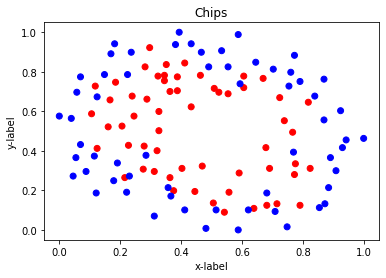

In [159]:
visualization_initial_data(chips, 'Chips')

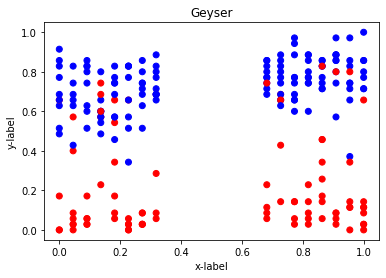

In [160]:
visualization_initial_data(geyser, 'Geyser')

In [161]:
x = geyser.values[:, :-1]
y = geyser.values[:, -1]

In [162]:
hyperparameter_optimization(x, y)

----------
Kernel:  Linear kernel
Parameter:  None
Accuracy:  0.9055194805194805
C:  1.0
----------
Kernel:  Polynomial kernel
Parameter:  2
Accuracy:  0.9099837662337662
C:  1.0
----------
Kernel:  Polynomial kernel
Parameter:  3
Accuracy:  0.8385551948051948
C:  0.5
----------
Kernel:  Polynomial kernel
Parameter:  4
Accuracy:  0.8339285714285714
C:  10.0
----------
Kernel:  Polynomial kernel
Parameter:  5
Accuracy:  0.8340909090909091
C:  0.5
----------
Kernel:  Gaussian kernel
Parameter:  1
Accuracy:  0.8964285714285714
C:  1.0
----------
Kernel:  Gaussian kernel
Parameter:  2
Accuracy:  0.8964285714285714
C:  0.1
----------
Kernel:  Gaussian kernel
Parameter:  3
Accuracy:  0.8918831168831168
C:  0.05
----------
Kernel:  Gaussian kernel
Parameter:  4
Accuracy:  0.8964285714285714
C:  0.5
----------
Kernel:  Gaussian kernel
Parameter:  5
Accuracy:  0.9055194805194805
C:  10.0


In [165]:
model = SMOModel(x, y, 1.0, LinearKernel(0))

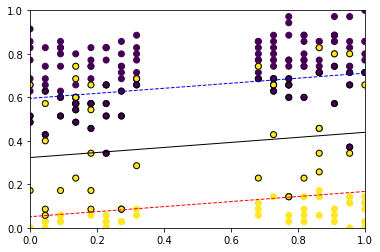

In [166]:
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

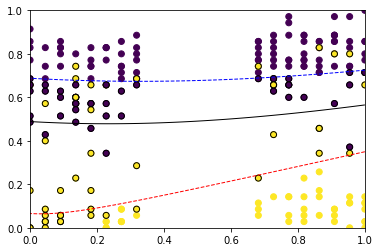

In [167]:
model = SMOModel(x, y, 1.0, PolynomialKernel(2))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

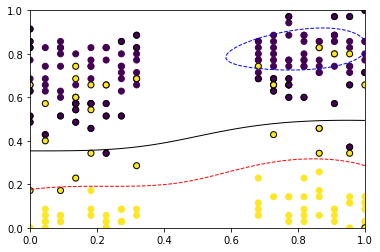

In [168]:
model = SMOModel(x, y, 1.0, GaussianKernel(5))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

In [169]:
x = chips.values[:, :-1]
y = chips.values[:, -1]

In [170]:
hyperparameter_optimization(x, y)

----------
Kernel:  Linear kernel
Parameter:  None
Accuracy:  0.4801724137931035
C:  10.0
----------
Kernel:  Polynomial kernel
Parameter:  2
Accuracy:  0.675
C:  10.0
----------
Kernel:  Polynomial kernel
Parameter:  3
Accuracy:  0.9166666666666666
C:  5.0
----------
Kernel:  Polynomial kernel
Parameter:  4
Accuracy:  0.6841954022988506
C:  50.0
----------
Kernel:  Polynomial kernel
Parameter:  5
Accuracy:  0.75
C:  0.05
----------
Kernel:  Gaussian kernel
Parameter:  1
Accuracy:  0.7985632183908047
C:  50.0
----------
Kernel:  Gaussian kernel
Parameter:  2
Accuracy:  0.8160919540229886
C:  100.0
----------
Kernel:  Gaussian kernel
Parameter:  3
Accuracy:  0.6810344827586207
C:  10.0
----------
Kernel:  Gaussian kernel
Parameter:  4
Accuracy:  0.799712643678161
C:  5.0
----------
Kernel:  Gaussian kernel
Parameter:  5
Accuracy:  0.7804597701149425
C:  50.0


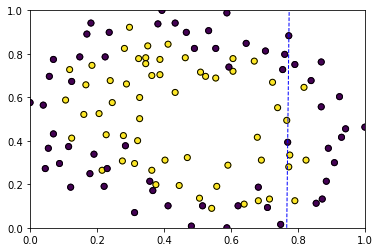

In [171]:
model = SMOModel(x, y, 1.0, LinearKernel(0))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

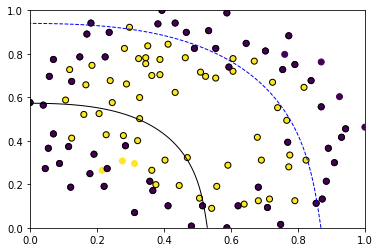

In [172]:
model = SMOModel(x, y, 1.0, PolynomialKernel(3))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)

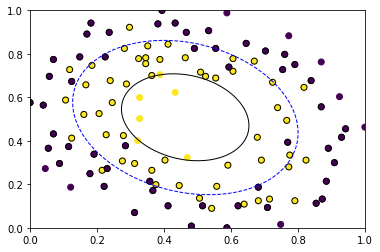

In [173]:
model = SMOModel(x, y, 1.0, GaussianKernel(2))
model.train()
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(model, ax)